## Explainable Deep Learning in Breast Cancer Prediction
 https://towardsdatascience.com/explainable-deep-learning-in-breast-cancer-prediction-ae36c638d2a4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# Load data
# Data downloaded from www.kaggle.com/simjeg/lymphoma-subtype-classification-fl-vs-cll

X = np.load('./data/X.npy') # images
Y = np.load('./data/Y.npy') # labels (0 = not diagnosed, 1 = diagnosed)

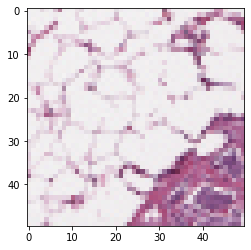

In [3]:
plt.imshow(X[-4])

In [4]:
# Shuffle dataset
# Shuffle indices, then use this to construct the dataset
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)
indices = list(indices)

X = X[indices]
Y = Y[indices]

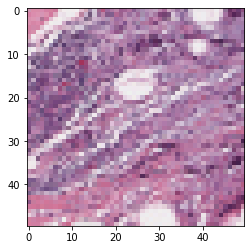

In [5]:
plt.imshow(X[-4])

In [6]:
# Creating a transformer to preprocess the data
# Deep learning works best when data ranges from 0 to 1
# Will be used to construct a pipeline below

class Scale(BaseEstimator, TransformerMixin):
    # Run nothing when the class is instantiated
    def __init__(self):
        pass

    # BaseEstimator: get_params and set_params methods
    # TransformerMixin: fit, transform, and fit_transform methods
    
    def fit(self, X, Y):
        return self
    
    def transform(self, X):
        return X / 255.0

In [7]:
# Function to split data set
from sklearn.model_selection import train_test_split

In [8]:
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(X, Y, test_size=0.2)

In [9]:
# Further split data set into validation and train sets
# Validation set is first 1000 inputs
X_train = X_train_raw.copy()
X_val = X_train[:1000]
X_train = X_train[1000:]
X_test = X_test_raw.copy()

In [10]:
Y_train = Y_train_raw.copy()
Y_val = Y_train[:1000]
Y_train = Y_train[1000:]
Y_test = Y_test_raw.copy()

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def getKerasCNNModel():
    batch_size = BATCH_SIZE
    epochs = EPOCH_SIZE  
    img_rows, img_cols = X_train.shape[1], X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    
    model = Sequential()
    
    # Input_shape needed when Conv2D is the first layer in the model
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    
    # Pooling layers: https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
    # Used to downsample the image after the nonlinearity is applied
    # Smaller than feature map
    # E.g.: 64 x 64 with a pool size 2 x 2 becomes 32 x 32
    # Average pooling: average for each patch
    # Max pooling: get max value for each patch
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Dropout: some weights randomly set to 0 to prevent overfitting, save computation
    # http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
    model.add(Dropout(0.25))
    
    # Steps repeated
    model.add(Conv2D(32, (3,3),  activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss= keras.losses.binary_crossentropy, 
                  optimizer=keras.optimizers.rmsprop(), 
                  metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [12]:
# Implementing above 2D ConvNet model as sklearn pipeline component

class KerasCNN(BaseEstimator, TransformerMixin):
    # Initializing with X and Y values
    def __init__(self, X_val=None, Y_val=None):
        self._model = getKerasCNNModel()
        self._batch_size = BATCH_SIZE
        self._epochs = EPOCH_SIZE
        self._X_val = X_val / 255.0
        self._Y_val = Y_val
        
    # Using getKerasCNNModel as fit function
    def fit(self, X, Y):
        self.history = self._model.fit(X, Y,
                        batch_size=self._batch_size,
                        verbose=1,
                        epochs=self._epochs,
                        validation_data=(self._X_val, self._Y_val))
        return self
    
    # No transform necessary - this was done in the scale class
    def transform(self, X):
        return X
    
    # Defining more functions, uses model methods
    def predict_proba(self, X):
        y_pred = self._model.predict(X)
        return y_pred
    
    def evaluate(self, X, y):
        return self._model.evaluate(X, y)
    

In [13]:
# Using our class to create the actual pipeline

from sklearn.pipeline import Pipeline

BATCH_SIZE = 32
EPOCH_SIZE = 500

simple_cnn_pipeline = Pipeline([
    ('scale', Scale()),
    ('CNN', KerasCNN(X_val=X_val, Y_val=Y_val))
])

In [14]:
# Training the network
simple_cnn_pipeline.fit(X_train, Y_train)

Train on 3437 samples, validate on 1000 samples
Epoch 1/500
3437/3437 [==============================] - 2s 670us/step - loss: 0.6853 - accuracy: 0.6168 - val_loss: 0.6709 - val_accuracy: 0.5960
Epoch 2/500
3437/3437 [==============================] - 1s 170us/step - loss: 0.5941 - accuracy: 0.6925 - val_loss: 0.5857 - val_accuracy: 0.7280
Epoch 3/500
3437/3437 [==============================] - 1s 173us/step - loss: 0.5731 - accuracy: 0.7230 - val_loss: 0.6183 - val_accuracy: 0.6470
Epoch 4/500
3437/3437 [==============================] - 1s 169us/step - loss: 0.5645 - accuracy: 0.7233 - val_loss: 0.5581 - val_accuracy: 0.7420
Epoch 5/500
3437/3437 [==============================] - 1s 170us/step - loss: 0.5504 - accuracy: 0.7376 - val_loss: 0.5916 - val_accuracy: 0.6930
Epoch 6/500
3437/3437 [==============================] - 1s 172us/step - loss: 0.5447 - accuracy: 0.7381 - val_loss: 0.5603 - val_accuracy: 0.7260
Epoch 7/500
3437/3437 [==============================] - 1s 172us/step

/home/jkim/.local/share/anaconda3/envs/env_tensorflow/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('scale', Scale()), ('CNN', KerasCNN(X_val=None, Y_val=None))],
         verbose=False)

In [15]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [16]:
explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [23]:
IDC_1_sample = X[7]
print(Y[7])
explanation_1 = explainer.explain_instance(
    IDC_1_sample, 
    classifier_fn = simple_cnn_pipeline.predict_proba, 
    top_labels=2, 
    hide_color=0, 
    num_samples=10000,
    segmentation_fn=segmenter
)

1


100% |########################################################################|


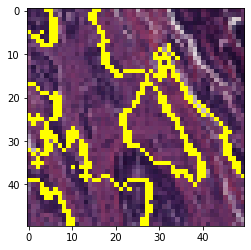

In [24]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation_1.get_image_and_mask(
    explanation_1.top_labels[0],
    positive_only=True,
    num_features=20,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))

0


100% |########################################################################|


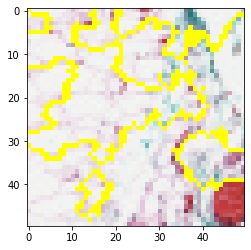

In [26]:
IDC_0_sample = X[1]
print(Y[1])
explanation_2 = explainer.explain_instance(
    IDC_0_sample,
    classifier_fn = simple_cnn_pipeline.predict_proba,
    top_labels=2,
    hide_color=0,
    num_samples=10000,
    segmentation_fn=segmenter
)

temp, mask = explanation_2.get_image_and_mask(
    explanation_2.top_labels[0],
    positive_only=True,
    num_features=20,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))